# Make a full overview of number counts by band by field

The reviewer requested that we produce number counts for each band on each field

In [58]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
#plt.rc('figure', figsize=(10, 6))
from matplotlib_venn import venn3

import herschelhelp 
from herschelhelp.utils import clean_table

from astropy.table import Table, vstack

import pyvo as vo

from pymoc import MOC

import time

import yaml



import warnings
warnings.filterwarnings('ignore')

In [2]:
#Then we establish the VO connection to our database
service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap"
                           )

In [3]:
fields = yaml.load(open('../../../dmu2/meta_main.yml', 'r'))['fields']

In [9]:
bands = [
    'mmt_g', 
    'omegacam_g', 
    'suprime_g', 
    'megacam_g', 
    'wfc_g', 
    'gpc1_g', 
    'decam_g', 
    '90prime_g', 
    'sdss_g',
    'isaac_k', 
    'moircs_k', 
    'ukidss_k', 
    'newfirm_k', 
    'wircs_k', 
    'hawki_k',
    'wircam_ks', 
    'vista_ks', 
    'moircs_ks', 
    'omega2000_ks', 
    'tifkam_ks'
]
mag_tables = {}


for band in bands:
    mag_tables[band] = {}
    for f in fields:
      
        mag_tables[band].update({f['name']: None})

In [80]:
start = time.time()
for band in bands:
    print(band)
    
    for f in fields:
     
     
        try:
            
            mag_tables[band].update({f['name'] : Table.read('./data/{}_{}.fits'.format(band, f['name']))})
            print("loaded {} from file ({} objects)".format(band, len(mag_tables[band][f['name']])))
            continue
        except FileNotFoundError:
            print("Querying VOX for {} mags on {}".format(band, f['name']))
    
        query = """
        SELECT 
        m_{}
        FROM herschelhelp.main
        WHERE herschelhelp.main.m_{} IS NOT NULL
        AND herschelhelp.main.field='{}'""".format(
            band, band, 
            f['name'].replace('Lockman-SWIRE','Lockman SWIRE' ).replace('HATLAS-NGP','NGP' ))

        job = service.submit_job(query, maxrec=100000000)
        job.run()
        job_url = job.url
        job_result = vo.dal.tap.AsyncTAPJob(job_url)
        start_time = time.time()
        wait = 10.
        while job.phase == 'EXECUTING':
            #print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
            time.sleep(wait) 
            #wait *=2

        print(job.phase)
        result = job_result.fetch_result()
        mag_tables[band].update({ f['name']: result.table})
        if len(mag_tables[band][f['name']]) != 0:
            print("Band {} field {} done in {} seconds with {} objects".format(
                band, 
                f['name'],                                                         
                round(time.time() - start_time), 
                len(mag_tables[band][f['name']])
            ))
    
print("Total time: {} seconds".format(round(time.time() - start)))

mmt_g
Querying VOX for mmt_g mags on HATLAS-NGP
COMPLETED
omegacam_g
Querying VOX for omegacam_g mags on HATLAS-NGP
COMPLETED
suprime_g
Querying VOX for suprime_g mags on HATLAS-NGP
COMPLETED
megacam_g
Querying VOX for megacam_g mags on HATLAS-NGP
COMPLETED
wfc_g
Querying VOX for wfc_g mags on HATLAS-NGP
COMPLETED
gpc1_g
Querying VOX for gpc1_g mags on HATLAS-NGP
COMPLETED
Band gpc1_g field HATLAS-NGP done in 69 seconds with 3089817 objects
decam_g
Querying VOX for decam_g mags on HATLAS-NGP
COMPLETED
90prime_g
Querying VOX for 90prime_g mags on HATLAS-NGP
COMPLETED
Band 90prime_g field HATLAS-NGP done in 35 seconds with 1099257 objects
sdss_g
Querying VOX for sdss_g mags on HATLAS-NGP
COMPLETED
isaac_k
Querying VOX for isaac_k mags on HATLAS-NGP
COMPLETED
moircs_k
Querying VOX for moircs_k mags on HATLAS-NGP
COMPLETED
ukidss_k
Querying VOX for ukidss_k mags on HATLAS-NGP
COMPLETED
Band ukidss_k field HATLAS-NGP done in 43 seconds with 1778877 objects
newfirm_k
Querying VOX for newfirm

In [37]:
mag_tables

{'mmt_g': {'AKARI-NEP': <Table masked=True length=0>
  m_mmt_g
    mag  
  float64
  -------, 'AKARI-SEP': <Table masked=True length=0>
  m_mmt_g
    mag  
  float64
  -------, 'Bootes': <Table masked=True length=0>
  m_mmt_g
    mag  
  float64
  -------, 'CDFS-SWIRE': <Table masked=True length=0>
  m_mmt_g
    mag  
  float64
  -------, 'COSMOS': <Table masked=True length=0>
  m_mmt_g
    mag  
  float64
  -------, 'EGS': <Table masked=True length=112907>
      m_mmt_g     
        mag       
      float64     
  ----------------
  25.0262350814973
  24.8055004271999
  26.7586308878581
  26.8136303557976
  26.5265249833877
  25.3982665621918
  24.7932205745817
  25.0049695460861
  25.3133781743952
               ...
  24.9616550650424
  25.4603839092271
  24.8054754283809
    24.69364457401
  26.6493553539056
  24.9149306939346
  24.3272071325981
  25.2301662011606
  25.1957844406397
  25.1038138580834, 'ELAIS-N1': <Table masked=True length=0>
  m_mmt_g
    mag  
  float64
  -------,

In [26]:
#service.maxrec=100000000
print(service.hardlimit)

20000000


Herschel Stripe 82 hits the hard limit on rows so we must get it from two queries

In [28]:

query = """
        SELECT 
        m_{}
        FROM herschelhelp.main
        WHERE herschelhelp.main.m_{} IS NOT NULL
        AND herschelhelp.main.field='{}'
        AND herschelhelp.main.m_decam_g<25
        """.format('decam_g', 'decam_g', 'Herschel-Stripe-82')

job = service.submit_job(query)
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
wait = 10.
while job.phase == 'EXECUTING':
            #print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(wait) 
            #wait *=2

print(job.phase)
result = job_result.fetch_result()

COMPLETED


In [29]:
len(result.table)

16912119

In [30]:
query = """
        SELECT 
        m_{}
        FROM herschelhelp.main
        WHERE herschelhelp.main.m_{} IS NOT NULL
        AND herschelhelp.main.field='{}'
        AND herschelhelp.main.m_decam_g>25
        """.format('decam_g', 'decam_g', 'Herschel-Stripe-82')

job = service.submit_job(query)
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
wait = 10.
while job.phase == 'EXECUTING':
            #print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(wait) 
            #wait *=2

print(job.phase)
result2 = job_result.fetch_result()

COMPLETED


In [31]:
len(result2.table)

7068890

In [34]:
hs82 = vstack([clean_table(result.table), clean_table(result2.table)])

In [35]:
len(hs82)

23981009

In [36]:
mag_tables['decam_g'].update({ 'Herschel-Stripe-82': hs82})

In [81]:
write = True
read = False
for band in bands:
    for f in fields:
        if write and (len(mag_tables[band][f['name']]) != 0):
            clean_table(mag_tables[band][f['name']]).write(
                './data/{}_{}.fits'.format(band, f['name']), overwrite = True
            )
            print('Table cleaned and written to ./data/{}_{}.fits'.format(band, f['name']))
        elif read:
            mag_tables[band].update( 
                {f['name'] : Table.read('./data/{}_{}.fits'.format(band, f['name']))} 
            ) 
    

Table cleaned and written to ./data/mmt_g_EGS.fits
Table cleaned and written to ./data/omegacam_g_CDFS-SWIRE.fits
Table cleaned and written to ./data/omegacam_g_COSMOS.fits
Table cleaned and written to ./data/omegacam_g_GAMA-09.fits
Table cleaned and written to ./data/omegacam_g_GAMA-12.fits
Table cleaned and written to ./data/omegacam_g_GAMA-15.fits
Table cleaned and written to ./data/omegacam_g_HATLAS-SGP.fits
Table cleaned and written to ./data/suprime_g_COSMOS.fits
Table cleaned and written to ./data/suprime_g_EGS.fits
Table cleaned and written to ./data/suprime_g_ELAIS-N1.fits
Table cleaned and written to ./data/suprime_g_GAMA-09.fits
Table cleaned and written to ./data/suprime_g_GAMA-15.fits
Table cleaned and written to ./data/suprime_g_Herschel-Stripe-82.fits
Table cleaned and written to ./data/suprime_g_XMM-LSS.fits
Table cleaned and written to ./data/megacam_g_AKARI-NEP.fits
Table cleaned and written to ./data/megacam_g_COSMOS.fits
Table cleaned and written to ./data/megacam_g

# Get depth tables to calculate area

In [102]:
depth_query = """
SELECT 
DISTINCT
hp_idx_o_10,"""
for band in bands:
    depth_query += " ferr_{}_mean,".format(band)

depth_query = depth_query.strip(',')
depth_query +=""" FROM depth.main"""

job = service.submit_job(depth_query, maxrec=100000000)
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
wait = 10.
while job.phase == 'EXECUTING':
    #print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(wait) 
    #wait *=2

print('Job {} after {} seconds.'.format(print(job.phase), round(time.time() - start_time)))    

result = job_result.fetch_result()
depth_result = result.table
   

Job still running after 0 seconds.
Job still running after 13 seconds.
Job still running after 33 seconds.
COMPLETED


In [104]:
depth_result = clean_table(depth_result)
depth_result.write('./data/depth_result.fits', overwrite = True)

In [105]:
depth_result

hp_idx_o_10,ferr_mmt_g_mean,ferr_omegacam_g_mean,ferr_suprime_g_mean,ferr_megacam_g_mean,ferr_wfc_g_mean,ferr_gpc1_g_mean,ferr_decam_g_mean,ferr_90prime_g_mean,ferr_sdss_g_mean,ferr_isaac_k_mean,ferr_moircs_k_mean,ferr_ukidss_k_mean,ferr_newfirm_k_mean,ferr_wircs_k_mean,ferr_hawki_k_mean,ferr_wircam_ks_mean,ferr_vista_ks_mean,ferr_moircs_ks_mean,ferr_omega2000_ks_mean,ferr_tifkam_ks_mean
,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1048576,nan,0.12590013,0.034778833,nan,nan,1.41293771046348,0.23891595,nan,nan,nan,nan,12.952429,nan,nan,nan,nan,nan,nan,nan,nan
1048577,nan,0.12849529,0.037005715,nan,nan,2.58553718755643,0.26041004,nan,nan,nan,nan,11.078862,nan,nan,nan,nan,5.14322257041931,nan,nan,nan
1048578,nan,0.13199174,0.037534576,nan,nan,12.1218815204508,0.5586686,nan,nan,nan,nan,11.872732,nan,nan,nan,nan,8.65422657208565,nan,nan,nan
1048579,nan,0.12674248,0.03794215,nan,nan,1.56400336904118,0.23023675,nan,nan,nan,nan,10.076924,nan,nan,nan,nan,6.18435804410414,nan,nan,nan
1048580,nan,0.14206333,0.04043122,nan,nan,1.39544255497938,0.22086646,nan,nan,nan,nan,8.667696,nan,nan,nan,nan,6.11608852039684,nan,nan,nan
1048581,nan,0.26306504,0.04343463,nan,nan,56.2829555178624,2.3186026,nan,nan,nan,nan,11.104447,nan,nan,nan,nan,6.84368888158647,nan,nan,nan
1048582,nan,0.116991796,0.03961132,nan,nan,3.78459515098651,0.26216686,nan,nan,nan,nan,9.996422,nan,nan,nan,nan,6.07616801972085,nan,nan,nan
1048583,nan,0.11553843,0.038907822,nan,nan,0.911389377062918,0.1591954,nan,nan,nan,nan,8.795542,nan,nan,nan,nan,6.55130145814684,nan,nan,nan


## Plot the histograms

In [82]:
bands_plotting = {
    'mmt_g':['MMT $g$','b'], 
    'omegacam_g':['Omegacam $g$','g'], 
    'suprime_g':['HSC $g$','r'],  
    'megacam_g':['Megacam $g$','c'],  
    'wfc_g':['WFC $g$','m'],  
    'gpc1_g':['GPC1 $g$','y'],  
    'decam_g':['DECam $g$','k'],  
    '90prime_g':['90Prime $g$','darkcyan'],  
    'sdss_g':['SDSS $g$','olive'], 
    'isaac_k':['ISAAC $K$','hotpink'],  
    'moircs_k':['MOIRCS $K$','indigo'],  
    'ukidss_k':['UKIDSS $K$','midnightblue'],  
    'newfirm_k':['Newfirm $K$','violet'],  
    'wircs_k':['WIRKS $K$','darkorchid'],  
    'hawki_k':['HAWKI $K$','royalblue'], 
    'wircam_ks':['WIRCam $Ks$','chartreuse'],  
    'vista_ks':['VISTA $Ks$','rebeccapurple'],  
    'moircs_ks':['MOIRCS $Ks$','gold'],  
    'omega2000_ks':['Omega2000 $Ks$','coral'],  
    'tifkam_ks':['TIFKAM $Ks$','gray']
}

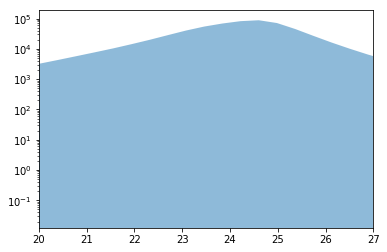

In [48]:
h = np.histogram(mag_tables['decam_g']['Herschel-Stripe-82']['m_decam_g'], bins = 100)
bin_width = (np.abs(h[1][5] - h[1][4]) )
area = 100
vals = plt.fill_between( h[1][:-1], h[0]/(bin_width*area), alpha=0.5)
plt.xlim(20.,27.)
plt.yscale('log')
#plt.ylim(1.e5,1.e7)

In [50]:
[b for b in mag_tables if b.endswith('g')]

['mmt_g',
 'omegacam_g',
 'suprime_g',
 'megacam_g',
 'wfc_g',
 'gpc1_g',
 'decam_g',
 '90prime_g',
 'sdss_g']

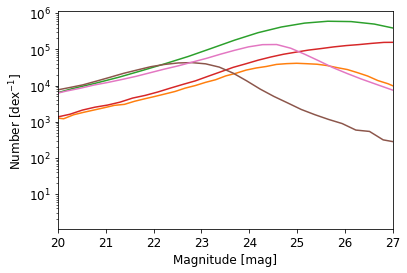

In [56]:
fig, ax = plt.subplots()


f = 'COSMOS'
area = 5
for band in [b for b in mag_tables if b.endswith('g')]:
    mask = np.isfinite(mag_tables[band][f]['m_'+band])
    mags = mag_tables[band][f][mask]['m_'+band]
    if not np.sum(mask)==0:
        #vz.hist(table[name][mask], bins='scott', label=label, alpha=.5)
        h = np.histogram(mags, bins = 100)
        bin_width = (np.abs(h[1][5] - h[1][4]) )
        #ax.fill_between( h[1][:-1], h[0]/bin_width)#, alpha=0.4)
        ax.plot( h[1][:-1], h[0]/bin_width , c=bands_plotting[band])#, alpha=0.4)


ax.legend(loc=1, fontsize=8)

plt.xlim(20.,27.)
plt.xlabel("Magnitude [mag]")
plt.yscale('log')

#plt.ylim(0.,0.4)
plt.ylabel('Number [dex$^{-1}$]')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)


#plt.savefig('./figs/numbers_g_en1.pdf', bbox_inches='tight')
#plt.savefig('./figs/numbers_g_en1.png', bbox_inches='tight')

In [112]:
for n, f in enumerate(fields):
    print(f['name'])

AKARI-NEP
AKARI-SEP
Bootes
CDFS-SWIRE
COSMOS
EGS
ELAIS-N1
ELAIS-N2
ELAIS-S1
GAMA-09
GAMA-12
GAMA-15
HDF-N
Herschel-Stripe-82
Lockman-SWIRE
HATLAS-NGP
SA13
HATLAS-SGP
SPIRE-NEP
SSDF
xFLS
XMM-13hr
XMM-LSS


In [116]:
areas = {}
for band in bands:
    areas.update({band: {}})
    for n, f in enumerate(fields):
        f = f['name']
        f_moc = MOC(filename='../../../dmu2/dmu2_field_coverages/{}_MOC.fits'.format(f))
    
        band_moc = MOC(10,
            depth_result[~np.isnan(depth_result['ferr_{}_mean'.format(band)])]['hp_idx_o_10']
        )
        area = band_moc.intersection( f_moc).area_sq_deg #.flattened(order=10)
        areas[band].update({f: area})
        


In [ ]:
#np.save('./data/areas.npy', areas) 
#areas = np.load('./data/areas.npy').item()

In [117]:
areas

{'mmt_g': {'AKARI-NEP': 0.0,
  'AKARI-SEP': 0.0,
  'Bootes': 0.0,
  'CDFS-SWIRE': 0.0,
  'COSMOS': 0.0,
  'EGS': 0.6655336327260426,
  'ELAIS-N1': 0.0,
  'ELAIS-N2': 0.0,
  'ELAIS-S1': 0.0,
  'GAMA-09': 0.0,
  'GAMA-12': 0.0,
  'GAMA-15': 0.0,
  'HDF-N': 0.0,
  'Herschel-Stripe-82': 0.0,
  'Lockman-SWIRE': 0.0,
  'HATLAS-NGP': 0.0,
  'SA13': 0.0,
  'HATLAS-SGP': 0.0,
  'SPIRE-NEP': 0.0,
  'SSDF': 0.0,
  'xFLS': 0.0,
  'XMM-13hr': 0.0,
  'XMM-LSS': 0.0},
 'omegacam_g': {'AKARI-NEP': 0.0,
  'AKARI-SEP': 0.0,
  'Bootes': 0.0,
  'CDFS-SWIRE': 12.969709611153812,
  'COSMOS': 1.2425480138087197,
  'EGS': 0.0,
  'ELAIS-N1': 0.0,
  'ELAIS-N2': 0.0,
  'ELAIS-S1': 0.0,
  'GAMA-09': 57.80578632331259,
  'GAMA-12': 61.070087406918006,
  'GAMA-15': 60.8652329582364,
  'HDF-N': 0.0,
  'Herschel-Stripe-82': 0.0,
  'Lockman-SWIRE': 0.0,
  'HATLAS-NGP': 0.0,
  'SA13': 0.0,
  'HATLAS-SGP': 284.82237178600843,
  'SPIRE-NEP': 0.0,
  'SSDF': 0.0,
  'xFLS': 0.0,
  'XMM-13hr': 0.0,
  'XMM-LSS': 0.0},
 'supri

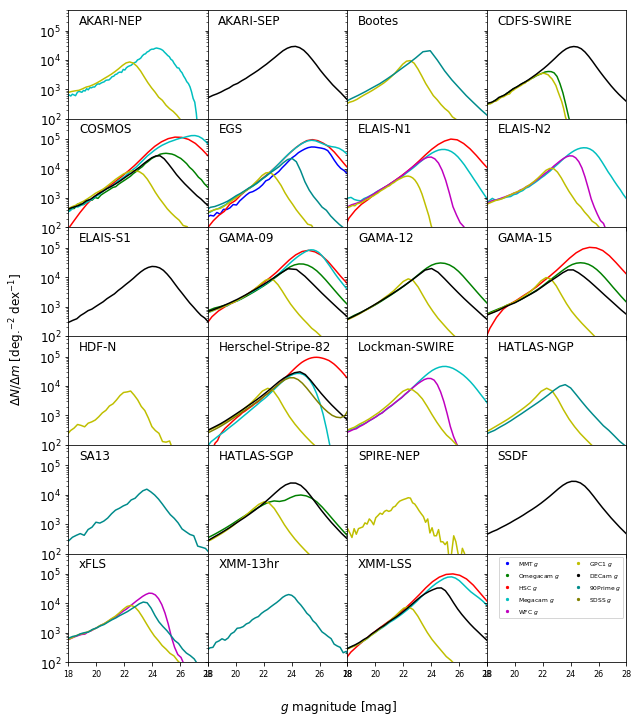

In [127]:
dim = [4,6]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
plt.rcParams.update({'font.size': 12})

#area_per_pixel  = MOC(10, (1234)).area_sq_degrees
for n, f in enumerate(fields):
    f = f['name']
        
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
   
    
    
    for band in [b for b in mag_tables if b.endswith('g')]:
        mask = np.isfinite(mag_tables[band][f]['m_'+band])
        #mask &= (bands[band][0]['field'] == f)

        
        area = areas[band][f]
        #area=f_moc.area_sq_deg
        mags = mag_tables[band][f][mask]['m_'+band]
        if not np.sum(mask)==0:
            #vz.hist(table[name][mask], bins='scott', label=label, alpha=.5)
            h = np.histogram(mags, bins = 100)
            bin_width = (np.abs(h[1][5] - h[1][4]) )
            #ax.fill_between( h[1][:-1], h[0]/bin_width)#, alpha=0.4)
            axes[x,y].plot( h[1][:-1], h[0]/(bin_width*area), c=bands_plotting[band][1])#, alpha=0.4)


 
   


    axes[x,y].get_xaxis().set_tick_params(direction='out')
    axes[x,y].xaxis.set_ticks_position('bottom')
    axes[x,y].tick_params(axis='x', labelsize=8)
    axes[x,y].set_xlim(18, 28)
    axes[x,y].set_ylim(1.e2, 0.5e6)
    axes[x,y].set_yscale('log')
    
    axes[x,y].scatter([-99],[-99], 
                      label=f, 
                      c='w', s=0.0001)
    axes[x,y].legend(frameon=False, loc=(-0.2, 0.8)) #, bbox_to_anchor=(0.1, 0.7, 0.2, 0.2)




for band in [b for b in mag_tables if b.endswith('g')]:
    axes[dim[1]-1,dim[0]-1].scatter([-99],[-99], 
                      label=bands_plotting[band][0], 
                      c=bands_plotting[band][1], s=5.)
axes[dim[1]-1,dim[0]-1].legend( prop={'size': 6},ncol=2)    
    
axes[dim[1]-1,dim[0]-1].tick_params(axis='x', labelsize=8)
#axes[dim[1]-1,dim[0]-1].set_xlabel('band')
    
fig.text(0.5, 0.07, '$g$ magnitude [mag]', ha='center')
fig.text(0.04, 0.5, '$\Delta N/\Delta m$ [deg.$^{-2}$ dex$^{-1}$]', va='center', rotation='vertical')

fig.set_size_inches(10, 12)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rc('axes', labelsize=12)
plt.savefig('./figs/numbers_g_allfields.pdf', bbox_inches='tight')
plt.savefig('./figs/numbers_g_allfields.png', bbox_inches='tight')

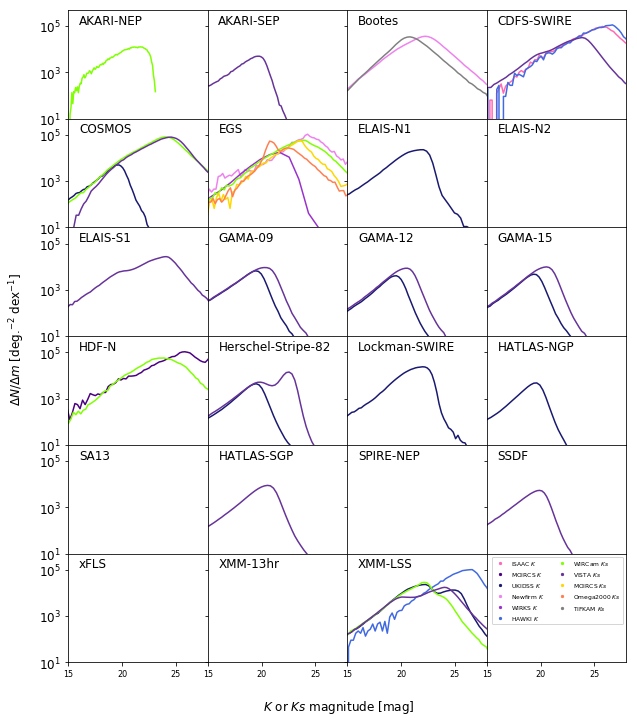

In [126]:
dim = [4,6]
fig, axes = plt.subplots(dim[1], dim[0], sharex=True, sharey=True)
plt.rcParams.update({'font.size': 12})

#area_per_pixel  = MOC(10, (1234)).area_sq_degrees
for n, f in enumerate(fields):
    f = f['name']
        
    x, y = np.floor_divide(n, dim[0]), np.remainder(n, dim[0])
    
    f_moc = MOC(filename='../../../dmu2/dmu2_field_coverages/{}_MOC.fits'.format(f))
    
    
    for band in [b for b in mag_tables if not b.endswith('g')]:
        mask = np.isfinite(mag_tables[band][f]['m_'+band])
        #mask &= (bands[band][0]['field'] == f)
        #band_moc = MOC(10,
        #    depth_result[~np.isnan(depth_result['ferr_{}_mean'.format(band)])]['hp_idx_o_10']
        #)
        
        #area = band_moc.intersection( f_moc) * area_per_pixel #.flattened(order=10)
        #area=f_moc.area_sq_deg
        area = areas[band][f]
        mags = mag_tables[band][f][mask]['m_'+band]
        if not np.sum(mask)==0:
            #vz.hist(table[name][mask], bins='scott', label=label, alpha=.5)
            h = np.histogram(mags, bins = 100)
            bin_width = (np.abs(h[1][5] - h[1][4]) )
            #ax.fill_between( h[1][:-1], h[0]/bin_width)#, alpha=0.4)
            axes[x,y].plot( h[1][:-1], h[0]/(bin_width*area), c=bands_plotting[band][1])#, alpha=0.4)


 
   


    axes[x,y].get_xaxis().set_tick_params(direction='out')
    axes[x,y].xaxis.set_ticks_position('bottom')
    axes[x,y].tick_params(axis='x', labelsize=8)
    axes[x,y].set_xlim(15, 28)
    axes[x,y].set_ylim(1.e1, 0.5e6)
    axes[x,y].set_yscale('log')
    
    axes[x,y].scatter([-99],[-99], 
                      label=f, 
                      c='w', s=0.0001)
    axes[x,y].legend(frameon=False, loc=(-0.2, 0.8))




for band in [b for b in mag_tables if not b.endswith('g')]:
    axes[dim[1]-1,dim[0]-1].scatter([-99],[-99], 
                      label=bands_plotting[band][0], 
                      c=bands_plotting[band][1], s=5.)
axes[dim[1]-1,dim[0]-1].legend( prop={'size': 6},ncol=2)    
    
axes[dim[1]-1,dim[0]-1].tick_params(axis='x', labelsize=8)
#axes[dim[1]-1,dim[0]-1].set_xlabel('band')
    
fig.text(0.5, 0.07, '$K$ or $Ks$ magnitude [mag]', ha='center')
fig.text(0.04, 0.5, '$\Delta N/\Delta m$ [deg.$^{-2}$ dex$^{-1}$]', va='center', rotation='vertical')

fig.set_size_inches(10, 12)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rc('axes', labelsize=12)
plt.savefig('./figs/numbers_K_allfields.pdf', bbox_inches='tight')
plt.savefig('./figs/numbers_K_allfields.png', bbox_inches='tight')